<font size="5">Part 1: Introduction and Setup


In [21]:
# in this geo_folder, you need 1) shape_ori 2) t0_fiber 3) t0_endo t0_epi stl 4) t0_tetra 
import os
import numpy as np
import trimesh
from scipy.spatial import KDTree
import vtk
import pyvista as pv
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import matplotlib.pyplot as plt
import re

# Base directory configuration
path = os.getcwd() + '/geo'

# Model configuration parameters
num_modes = 20          # Number of modes for analysis
numoftime = 31         # Total number of time steps
clip_ratio = 0.97      # Clipping ratio for geometry

# Physiological parameters
time_period = 800      # Cardiac cycle duration (ms)
EDP = 11              # End-diastolic pressure (mmHg)
PSP = 125             # Peak systolic pressure (mmHg)
t0 = 171              # Time to peak tension (ms)

# Create output directory
if not os.path.exists(path + '/shape'):
    os.makedirs(path + '/shape')

<font size="5">Part 2: Surface-to-Tetrahedral Mesh Interpolation

In [2]:
"""
Surface-to-Tetrahedral Mesh Interpolation

This script performs displacement interpolation from surface meshes to tetrahedral mesh:
1. Reads time series of surface meshes (STL files)
2. Reads reference tetrahedral mesh (VTU file)
3. Interpolates surface displacements to tetrahedral mesh using nearest neighbor
4. Generates deformed tetrahedral meshes for each time step
"""

def read_vtu_file(filename):
    """
    Read VTU file and extract grid and points.
    
    Args:
        filename (str): Path to the VTU file
        
    Returns:
        tuple: (vtk.UnstructuredGrid, np.array) - Grid object and point coordinates
    """
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    grid = reader.GetOutput()
    points = np.array([grid.GetPoint(i) for i in range(grid.GetNumberOfPoints())])
    return grid, points

def interpolate_displacements_nn(surface_points, surface_displacements, vtu_points):
    """
    Interpolate displacements using nearest neighbor approach.
    
    Args:
        surface_points (np.array): Original surface points
        surface_displacements (np.array): Surface point displacements
        vtu_points (np.array): Target VTU points
        
    Returns:
        np.array: Interpolated displacements for VTU points
    """
    tree = KDTree(surface_points)
    _, indices = tree.query(vtu_points)
    return surface_displacements[indices]

# ===== Path Configuration =====
# Setup input/output paths
stl_path = os.path.join(path, "image_shape")    # STL files directory
vtu_file = os.path.join(path, "t0_tetra.vtu")      # Input VTU file
output_dir = os.path.join(path, "tetra_vtks")   # Output directory
os.makedirs(output_dir, exist_ok=True)

# ===== Load Initial Data =====
# Read tetrahedral mesh
vtu_grid, vtu_points = read_vtu_file(vtu_file)

# Load reference surface mesh
t0_stl = trimesh.load(os.path.join(stl_path, "t0.stl"))
t0_points = t0_stl.vertices

# ===== Process Time Series =====
for i in range(0, numoftime):
    # Load current timestep STL
    stl_filename = os.path.join(stl_path, f"t{i}.stl")
    if not os.path.exists(stl_filename):
        print(f"File {stl_filename} does not exist. Skipping.")
        continue

    # Read and validate current mesh
    current_stl = trimesh.load(stl_filename)
    current_points = current_stl.vertices
    if len(current_points) != len(t0_points):
        raise ValueError(f"Point count mismatch between t0.stl and t{i}.stl")

    # Calculate surface displacements
    surface_displacements = current_points - t0_points

    # Interpolate to volumetric mesh
    interpolated_displacements = interpolate_displacements_nn(
        t0_points, 
        surface_displacements, 
        vtu_points
    )

    # Apply displacements with constraints
    new_vtu_points = vtu_points + interpolated_displacements
    new_vtu_points[:, 2] = np.minimum(new_vtu_points[:, 2], 0)  # Z-coordinate constraint

    # Create new VTK grid
    vtk_points = vtk.vtkPoints()
    for point in new_vtu_points:
        vtk_points.InsertNextPoint(point)

    new_grid = vtk.vtkUnstructuredGrid()
    new_grid.SetPoints(vtk_points)

    # Copy cell topology from original grid
    for j in range(vtu_grid.GetNumberOfCells()):
        cell = vtu_grid.GetCell(j)
        new_grid.InsertNextCell(cell.GetCellType(), cell.GetPointIds())

    # Save output VTK file
    output_vtk = os.path.join(output_dir, f"t{i}.vtk")
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(output_vtk)
    writer.SetInputData(new_grid)
    writer.Write()

print("Tetrahedral VTK files saved.")

Tetrahedral VTK files saved.


<font size="5">Part 3: Fiber Direction Transfer for Cardiac Mesh

In [3]:
"""
Fiber Direction Transfer for Cardiac Mesh

This script transfers fiber, sheet, and sheet-normal vectors from an interior mesh 
to a surface mesh using nearest-neighbor interpolation.

Input:
- Tetrahedral mesh (t0_tetra.vtu)
- Fiber direction data (t0_fiber.vtu)

Output:
- Updated tetrahedral mesh with fiber orientations
"""


# ===== Utility Functions =====
def read_vtu_file(filename):
    """
    Read VTU file and return VTK unstructured grid.
    
    Args:
        filename (str): Path to VTU file
        
    Returns:
        vtk.vtkUnstructuredGrid: VTK geometry object
    """
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    return reader.GetOutput()

def transfer_vectors(geo_mesh, geo_interior, fiber_name='fiber', sheet_name='sheet', sheet_normal_name='sheet_normal'):
    """
    Transfer vector fields from interior to surface mesh using nearest neighbor interpolation.
    
    Args:
        geo_mesh (vtk.vtkUnstructuredGrid): Target mesh
        geo_interior (vtk.vtkUnstructuredGrid): Source mesh with fiber data
        fiber_name (str): Name of fiber direction array
        sheet_name (str): Name of sheet direction array
        sheet_normal_name (str): Name of sheet normal array
    """
    # Extract point coordinates
    mesh_points = np.array([geo_mesh.GetPoint(i) for i in range(geo_mesh.GetNumberOfPoints())])
    interior_points = np.array([geo_interior.GetPoint(i) for i in range(geo_interior.GetNumberOfPoints())])

    # Find nearest neighbors using KDTree
    tree = cKDTree(interior_points)
    _, indices = tree.query(mesh_points)

    # Get source vector fields
    fiber_vectors = geo_interior.GetCellData().GetArray(fiber_name)
    sheet_vectors = geo_interior.GetCellData().GetArray(sheet_name)
    sheet_normal_vectors = geo_interior.GetCellData().GetArray(sheet_normal_name)

    # Initialize target vector fields
    vector_arrays = {
        fiber_name: vtk.vtkFloatArray(),
        sheet_name: vtk.vtkFloatArray(),
        sheet_normal_name: vtk.vtkFloatArray()
    }
    
    # Setup vector arrays
    for name, array in vector_arrays.items():
        array.SetName(name)
        array.SetNumberOfComponents(3)
        array.SetNumberOfTuples(geo_mesh.GetNumberOfPoints())

    # Transfer vectors to target mesh
    for i in range(geo_mesh.GetNumberOfPoints()):
        # Get vectors from nearest point
        fiber = fiber_vectors.GetTuple(indices[i])
        sheet = sheet_vectors.GetTuple(indices[i])
        sheet_normal = sheet_normal_vectors.GetTuple(indices[i])

        # Assign vectors to target arrays
        vector_arrays[fiber_name].SetTuple(i, fiber)
        vector_arrays[sheet_name].SetTuple(i, sheet)
        vector_arrays[sheet_normal_name].SetTuple(i, sheet_normal)

    # Add vector fields to target mesh
    for array in vector_arrays.values():
        geo_mesh.GetPointData().AddArray(array)

# ===== Main Processing =====
# Configure file paths
geo_mesh_file = path + '/t0_tetra.vtu'
geo_interior_file = path + '/t0_fiber.vtu'

# Load mesh data
geo_mesh = read_vtu_file(geo_mesh_file)
geo_interior = read_vtu_file(geo_interior_file)

# Transfer fiber orientations
transfer_vectors(
    geo_mesh, 
    geo_interior,
    fiber_name='fiber vectors',
    sheet_name='sheet vectors',
    sheet_normal_name='sheet normal vectors'
)

print("Fiber directions successfully transferred to tetrahedral mesh.")

Fiber directions successfully transferred to tetrahedral mesh.


<font size="5">Part 4: Label Assignment for Cardiac Mesh Points

In [ ]:
"""
Label Assignment for Cardiac Mesh Points

This cell assigns labels to mesh nodes:
- 0: interior
- 1: endocardium (endo)
- 2: epicardium (epi)
- 3: base

Labels are determined by proximity to endo/epi STL surfaces and z-coordinate for base.
"""


def load_stl_as_points(stl_file):
    """
    Load an STL file and return its points as a numpy array.
    Args:
        stl_file (str): Path to the STL file.
    Returns:
        np.ndarray: Array of point coordinates.
    """
    mesh = pv.read(stl_file)
    return mesh.points

# Extract mesh node coordinates
nodes = np.array([geo_mesh.GetPoint(i) for i in range(geo_mesh.GetNumberOfPoints())])
num_points = nodes.shape[0]

# Load endocardium and epicardium surface points
endo_points = load_stl_as_points(os.path.join(path, "t0_endo.stl"))
epi_points = load_stl_as_points(os.path.join(path, "t0_epi.stl"))

# Initialize all labels to 0 (interior)
labels = np.zeros(num_points, dtype=int)

# Tolerance for floating-point comparison
tolerance = 1e-6

# Assign labels based on proximity to endo and epi surfaces
for i in range(num_points):
    if np.any(np.linalg.norm(nodes[i] - endo_points, axis=1) < tolerance):
        labels[i] = 1  # Endocardium
    elif np.any(np.linalg.norm(nodes[i] - epi_points, axis=1) < tolerance):
        labels[i] = 2  # Epicardium

# Assign label 3 to base points (z close to 0)
base_indices = np.where(nodes[:, 2] > -1e-6)[0]
labels[base_indices] = 3

# Add labels as a VTK array to the mesh
vtk_labels = vtk.vtkIntArray()
vtk_labels.SetNumberOfComponents(1)
vtk_labels.SetName("label")
for label in labels:
    vtk_labels.InsertNextValue(label)

geo_mesh.GetPointData().AddArray(vtk_labels)

print("Labels assigned to mesh points: 0=interior, 1=endo, 2=epi, 3=base.")

Labels assigned to mesh points: 0=interior, 1=endo, 2=epi, 3=base.


In [10]:
"""
Save Modified Cardiac Mesh to VTK File

This cell saves the modified geo_mesh (with new labels or parameters) to a .vtk file.
"""

def save_vtk_file(geometry, filename):
    """
    Save a VTK unstructured grid to a .vtk file.
    Args:
        geometry (vtk.vtkUnstructuredGrid): The mesh to save.
        filename (str): Output file path.
    """
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(filename)
    writer.SetInputData(geometry)
    writer.Write()

# Define output file path
output_file = os.path.join(path, 't0_withpara.vtk')

# Save the modified mesh
save_vtk_file(geo_mesh, output_file)

print("New VTK file with labels has been created successfully.")

New VTK file with labels has been created successfully.


<font size="5">Part 5: Chamber Volume Calculation and Sudden Slope Detection

In [11]:
"""
Chamber Volume Calculation and Sudden Slope Detection

This cell:
- Computes nodal area and chamber volume for each VTK mesh in a folder
- Saves updated meshes with nodal area as a new point data array
- Records chamber volumes for all frames
- Detects the frame with a sudden slope increase after the minimum volume (start of diastole)
"""

def compute_chamber_volume(nodal_area, coords):
    """
    Compute the chamber volume based on nodal areas and coordinates.
    """
    return np.sum(np.einsum('ij,ij->i', nodal_area, coords)) / 3.0

def compute_nodal_area_for_vtk(vtk_file_path):
    """
    Read a VTK file, compute nodal area for endocardial faces, 
    adjust area vector direction, calculate chamber volume, 
    and save the updated mesh with nodal area as point data.
    """
    # Read the VTK file
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()
    mesh_data = reader.GetOutput()

    # Get node coordinates and element connectivity
    coords = vtk_to_numpy(mesh_data.GetPoints().GetData())
    n_el = mesh_data.GetNumberOfCells()
    els = np.zeros((n_el, 4), dtype=int)
    for i in range(n_el):
        for n_sel in range(4):
            els[i, n_sel] = int(mesh_data.GetCell(i).GetPointId(n_sel))

    # Extract endocardial faces (label==1)
    faces_connectivity = np.array([[0, 2, 1], [0, 1, 3], [1, 2, 3], [2, 0, 3]])
    faces_endo = []
    for kk in range(n_el):
        el_points = els[kk, :]
        for jj in range(4):
            if all(labels[int(v)] == 1 for v in el_points[faces_connectivity[jj]]):
                faces_endo.append(el_points[faces_connectivity[jj]])
    faces_endo = np.array(faces_endo, dtype=int)

    # Set base center
    base_center = np.array([0.0, 0.0, 0.0])

    # Calculate nodal area
    nodal_area = np.zeros((coords.shape[0], 3))
    for face in faces_endo:
        area_vector = 0.5 * np.cross(coords[face[1]] - coords[face[0]], coords[face[2]] - coords[face[0]])
        face_center = np.mean(coords[face], axis=0)
        V = face_center - base_center
        if np.dot(V, area_vector) < 0:
            area_vector = -area_vector
        for node_index in face:
            nodal_area[node_index, :] += area_vector / 3.0

    # Compute chamber volume
    chamber_volume = compute_chamber_volume(nodal_area, coords)

    # Add nodal area to mesh point data
    vtk_area = vtk.vtkFloatArray()
    vtk_area.SetNumberOfComponents(3)
    vtk_area.SetName("Nodal_area")
    for i in range(len(nodal_area)):
        vtk_area.InsertNextTuple(nodal_area[i])
    mesh_data.GetPointData().AddArray(vtk_area)

    # Save updated mesh
    output_dir = os.path.join(os.path.dirname(vtk_file_path), "chamber_volume")
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, os.path.basename(vtk_file_path))
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(output_file)
    writer.SetInputData(mesh_data)
    writer.Write()

    return chamber_volume

def process_all_vtk_in_folder(folder_path):
    """
    Process all VTK files in a folder, compute nodal areas and chamber volumes,
    and save chamber volumes to a text file.
    """
    vtk_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.vtk')],
        key=lambda x: int(x[1:].split('.')[0])  # Extract the numerical part after 't'
    )
    chamber_volumes = []
    previous_volume = None

    for vtk_file in vtk_files:
        vtk_file_path = os.path.join(folder_path, vtk_file)
        chamber_volume = compute_nodal_area_for_vtk(vtk_file_path)
        if previous_volume is not None:
            volume_difference = chamber_volume - previous_volume
            # print(f"Volume difference from previous file: {volume_difference}")
        previous_volume = chamber_volume
        chamber_volumes.append((vtk_file, chamber_volume))

    # Save chamber volumes to a text file
    volume_output_path = os.path.join(folder_path, "chamber_volumes.txt")
    with open(volume_output_path, 'w') as volume_file:
        for vtk_file, volume in chamber_volumes:
            volume_file.write(f"{vtk_file}: {volume}\n")

    return chamber_volumes

def find_sudden_slope_increase(chamber_volumes, threshold=2):
    """
    Find the frame after the minimum volume where the slope suddenly increases.
    Args:
        chamber_volumes (list of tuples): [(frame_name, volume), ...]
        threshold (float): Relative increase threshold to detect sudden slope increase.
    Returns:
        str: Frame name where the slope suddenly increases after the minimum volume.
    """
    frames, volumes = zip(*chamber_volumes)
    volumes = np.array(volumes)
    slopes = np.diff(volumes)
    min_volume_index = np.argmin(volumes)
    for i in range(min_volume_index, len(slopes) - 1):
        if slopes[i + 1] > threshold * slopes[i]:
            return frames[i + 1], i + 1
    return None, None

# Main execution
input_folder = os.path.join(path, 'tetra_vtks')
chamber_volumes = process_all_vtk_in_folder(input_folder)
sudden_slope_frame, start_diastolic_frame_index = find_sudden_slope_increase(chamber_volumes)
frames, volumes = zip(*chamber_volumes)
min_volume_index = np.argmin(volumes)

# Calculate unloaded frame index (1/3 of the total frames)
unloaded_frame_index = int((numoftime - 1 - start_diastolic_frame_index) / 3) + start_diastolic_frame_index - 1

print(f"Unloaded frame: {unloaded_frame_index}")
print(f"Minimum volume frame index: {min_volume_index}")

Unloaded frame: 17
Minimum volume frame index: 11


<font size="5">Part 6: Fiber Direction Transformation for Unloaded Configuration

In [12]:
"""
Fiber Direction Transformation for Unloaded Configuration

This script computes and transforms fiber/sheet/sheet-normal directions from the reference 
to the unloaded configuration using deformation gradient.
"""

def GradientOperator_AvgBased(Coords, Els, tolerance=1e-10):
    """
    Compute gradient operators for mesh deformation analysis.
    
    Args:
        Coords (np.array): (N, 3) Node coordinates
        Els (np.array): (M, 4) Tetrahedral elements
        tolerance (float): Tolerance for degenerate elements
        
    Returns:
        tuple: (dFdx, dFdy, dFdz) Gradient operators
    """
    n_el = Els.shape[0]
    n_points = Coords.shape[0]
    
    # Initialize arrays
    dFcdx = np.zeros((n_el, n_points))
    dFcdy = np.zeros((n_el, n_points))
    dFcdz = np.zeros((n_el, n_points))
    Vol_el = np.zeros((n_el, 1))
    Nodal_volume = np.zeros((n_points, 1))
    dFdx = np.zeros((n_points, n_points))
    dFdy = np.zeros((n_points, n_points))
    dFdz = np.zeros((n_points, n_points))

    # Compute element-wise gradients
    for sel_el in range(n_el):
        AA = np.zeros((3, 3))
        AA[0, :] = Coords[Els[sel_el, 1]] - Coords[Els[sel_el, 0]]
        AA[1, :] = Coords[Els[sel_el, 2]] - Coords[Els[sel_el, 0]]
        AA[2, :] = Coords[Els[sel_el, 3]] - Coords[Els[sel_el, 0]]
        
        det_A = np.linalg.det(AA)
        if abs(det_A) < tolerance:
            continue

        invA = np.linalg.inv(AA)

        # Compute gradients for each direction
        for i, arr in enumerate([dFcdx, dFcdy, dFcdz]):
            arr[sel_el, Els[sel_el, 0]] = -np.sum(invA[i, :])
            arr[sel_el, Els[sel_el, 1:]] = invA[i, :]

    # Volume weighted projection
    for i in range(n_el):
        v1 = Coords[Els[i,3]] - Coords[Els[i,0]]
        v2 = Coords[Els[i,2]] - Coords[Els[i,0]]
        v3 = Coords[Els[i,1]] - Coords[Els[i,0]]
        Vol_el[i] = abs(np.dot(v1, np.cross(v2, v3))) / 6.0
        for n_sel in Els[i]:
            Nodal_volume[n_sel] += Vol_el[i] / 4.0

    # Compute final gradients
    for i in range(n_points):
        Els_per_node = np.where(Els == i)[0]
        for sel_el in Els_per_node:
            weight = Vol_el[sel_el] / (4.0 * Nodal_volume[i])
            dFdx[i] += dFcdx[sel_el] * weight
            dFdy[i] += dFcdy[sel_el] * weight
            dFdz[i] += dFcdz[sel_el] * weight

    return dFdx, dFdy, dFdz

def read_vtk_mesh(filename):
    """
    Read coordinates and connectivity from VTK file.
    
    Args:
        filename (str): Path to VTK file
        
    Returns:
        tuple: (Coords, Els) Node coordinates and element connectivity
    """
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.Update()
    mesh = reader.GetOutput()

    # Extract elements
    n_el = mesh.GetNumberOfCells()
    Els = np.zeros((n_el, 4), dtype=int)
    for i in range(n_el):
        for j in range(4):
            Els[i,j] = mesh.GetCell(i).GetPointId(j)
            
    # Extract coordinates
    Coords = vtk_to_numpy(mesh.GetPoints().GetData())
    
    return Coords, Els

def compute_deformation_gradient(t0_coords, t_coords, Els):
    """
    Compute deformation gradient F between reference and current configurations.
    
    Args:
        t0_coords (np.array): Reference coordinates
        t_coords (np.array): Current coordinates
        Els (np.array): Element connectivity
        
    Returns:
        np.array: (N, 3, 3) Deformation gradient tensor for each node
    """
    dFdx, dFdy, dFdz = GradientOperator_AvgBased(t0_coords, Els)
    n_points = t0_coords.shape[0]
    F = np.zeros((n_points, 3, 3))

    disp = t_coords - t0_coords
    for i in range(n_points):
        F[i, 0] = np.dot(dFdx[i], disp)
        F[i, 1] = np.dot(dFdy[i], disp)
        F[i, 2] = np.dot(dFdz[i], disp)
        np.fill_diagonal(F[i], F[i].diagonal() + 1)

    return F

def compute_loading_fsn(F, fibers, sheets, sheet_normals):
    """
    Transform fiber directions using deformation gradient.
    
    Args:
        F (np.array): (N, 3, 3) Deformation gradient
        fibers, sheets, sheet_normals (np.array): Reference directions
        
    Returns:
        tuple: Transformed fiber directions
    """
    def normalize(v):
        norm = np.linalg.norm(v)
        return v / norm if norm > 1e-10 else v

    n_points = F.shape[0]
    deformed_fibers = np.array([normalize(F[i] @ fibers[i]) for i in range(n_points)])
    deformed_sheets = np.array([normalize(F[i] @ sheets[i]) for i in range(n_points)])
    deformed_sheet_normals = np.array([normalize(F[i] @ sheet_normals[i]) for i in range(n_points)])

    return deformed_fibers, deformed_sheets, deformed_sheet_normals

# Main execution
if __name__ == "__main__":
    # Read reference data
    t0_vtk = f"{path}/t0_withpara.vtk"
    t1_vtk = f"{path}/tetra_vtks/t{unloaded_frame_index}.vtk"
    
    # Load reference FSN and coordinates
    mesh = vtk.vtkUnstructuredGridReader()
    mesh.SetFileName(t0_vtk)
    mesh.Update()
    data = mesh.GetOutput()
    
    fibers = vtk_to_numpy(data.GetPointData().GetArray("fiber vectors"))
    sheets = vtk_to_numpy(data.GetPointData().GetArray("sheet vectors"))
    sheet_normals = vtk_to_numpy(data.GetPointData().GetArray("sheet normal vectors"))
    labels = vtk_to_numpy(data.GetPointData().GetArray("label"))
    
    # Read meshes and compute deformation
    t0_coords, Els = read_vtk_mesh(t0_vtk)
    t_coords, _ = read_vtk_mesh(t1_vtk)
    F = compute_deformation_gradient(t0_coords, t_coords, Els)
    
    # Transform fiber directions
    deformed_fibers, deformed_sheets, deformed_sheet_normals = compute_loading_fsn(
        F, fibers, sheets, sheet_normals
    )
    
    # Save results
    points = vtk.vtkPoints()
    for coord in t_coords:
        points.InsertNextPoint(coord)

    grid = vtk.vtkUnstructuredGrid()
    grid.SetPoints(points)
    
    for element in Els:
        cell = vtk.vtkTetra()
        for i, node_id in enumerate(element):
            cell.GetPointIds().SetId(i, node_id)
        grid.InsertNextCell(cell.GetCellType(), cell.GetPointIds())

    # Add fiber directions and labels
    for name, data in [
        ("fiber vectors", deformed_fibers),
        ("sheet vectors", deformed_sheets),
        ("sheet normal vectors", deformed_sheet_normals)
    ]:
        arr = vtk.vtkDoubleArray()
        arr.SetNumberOfComponents(3)
        arr.SetName(name)
        for vec in data:
            arr.InsertNextTuple(vec)
        grid.GetPointData().AddArray(arr)

    # Add labels
    label_arr = vtk.vtkIntArray()
    label_arr.SetName("label")
    for label in labels:
        label_arr.InsertNextValue(label)
    grid.GetPointData().AddArray(label_arr)

    # Save to file
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(f"{path}/unloaded_geo.vtk")
    writer.SetInputData(grid)
    writer.Write()

    print("Fiber directions successfully transformed to unloaded configuration.")

Fiber directions successfully transformed to unloaded configuration.


<font size="5">Part 7: Nodal Volume and Area Computation

In [16]:
"""
Nodal Volume and Area Computation

Compute and assign nodal volumes and areas for the tetrahedral mesh,
with special handling of endocardial surface areas using sheet vector orientation.
"""

def read_vtk_file(filepath):
    """
    Reads a VTK file and returns the unstructured grid.
    Args:
        filepath: Path to the VTK file.
    Returns:
        vtkUnstructuredGrid object.
    """
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filepath)
    reader.Update()
    return reader.GetOutput()

def save_vtk_file(geometry, filename):
    """
    Save a VTK file after modifications.
    Args:
        geometry: VTK geometry to save
        filename: Output file path
    """
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(filename)
    writer.SetInputData(geometry)
    writer.Write()

# ===== Load Geometry =====
geometry_vtk_path = path + "/unloaded_geo.vtk"
geo_mesh = read_vtk_file(geometry_vtk_path)

# Extract element connectivity
n_el = geo_mesh.GetNumberOfCells()
Els = np.zeros((n_el,4), dtype=int)
for i in range(n_el):
    cell_type = geo_mesh.GetCellType(i)
    n_nodes_el = geo_mesh.GetCell(i).GetPointIds().GetNumberOfIds()
    for n_sel in range(n_nodes_el):
        Els[i,n_sel] = int(geo_mesh.GetCell(i).GetPointId(n_sel))

# ===== Find Endocardial Faces =====
faces_connectivity = np.array([[0,2,1],[0,1,3],[1,2,3],[2,0,3]])
Faces_Endo = []
start_faces = True

for kk in range(n_el):
    el_points = Els[kk,:]
    for jj in range(4):
        if all(labels[int(v)] == 1 for v in el_points[faces_connectivity[jj]]):
            if start_faces:
                Faces_Endo = np.array(el_points[faces_connectivity[jj]], dtype=int).reshape(1,-1)
                start_faces = False
            else:
                Faces_Endo = np.concatenate((Faces_Endo,np.array(el_points[faces_connectivity[jj]], dtype=int).reshape(1,-1)), 0)

# ===== Compute Nodal Areas =====
Coords = vtk_to_numpy(geo_mesh.GetPoints().GetData())
Nodal_area = np.zeros((Coords.shape[0],3))

total_triangle_area = 0
threshold = 0
point_data = geo_mesh.GetPointData()
sheet_vtk = point_data.GetArray("sheet vectors")
sheet = vtk_to_numpy(sheet_vtk)

for jj in range(Faces_Endo.shape[0]):
    # Calculate area vector
    area_vector = 0.5*(np.cross(
        Coords[Faces_Endo[jj][1],:]-Coords[Faces_Endo[jj][0],:],
        Coords[Faces_Endo[jj][2],:]-Coords[Faces_Endo[jj][0],:]
    ))
    
    area_magnitude = np.linalg.norm(area_vector)
    total_triangle_area += area_magnitude

    for ll in range(3):
        node_index = Faces_Endo[jj][ll]
        
        # Normalize vectors
        area_vector_normal = area_vector / np.linalg.norm(area_vector)
        reference_normal = sheet[node_index] / np.linalg.norm(sheet[node_index])
        normal_dot_product = np.dot(area_vector_normal, reference_normal)

        # Adjust area vector direction
        if normal_dot_product < threshold:
            area_vector = -area_vector
        
        Nodal_area[node_index, :] += area_vector / 3.0

# ===== Compute Nodal Volumes =====
Vol_el = np.zeros((n_el,1))
n_points = Coords.shape[0]
Nodal_volume = np.zeros((n_points,1))

for i in range(n_el):
    Vol_el[i] = 1.0/6.0*abs((Coords[Els[i,3],:]-Coords[Els[i,0],:]).dot(
        np.cross(Coords[Els[i,2],:]-Coords[Els[i,0],:],
                Coords[Els[i,1],:]-Coords[Els[i,0],:])
    ))
    for n_sel in Els[i]:
        Nodal_volume[n_sel] += Vol_el[i]/4.0

# ===== Add Data to VTK Mesh =====
# Add nodal volume
vtk_volume = vtk.vtkFloatArray()
vtk_volume.SetNumberOfComponents(1)
vtk_volume.SetName("Nodal_volume")
for i in range(len(Nodal_volume)):
    vtk_volume.InsertNextValue(Nodal_volume[i])
geo_mesh.GetPointData().AddArray(vtk_volume)

# Add nodal area
vtk_area = vtk.vtkFloatArray()
vtk_area.SetNumberOfComponents(3)
vtk_area.SetName("Nodal_area")
for i in range(len(Nodal_area)):
    vtk_area.InsertNextTuple(Nodal_area[i])
geo_mesh.GetPointData().AddArray(vtk_area)

# ===== Calculate and Print Totals =====
total_volume_nodal = np.sum(Nodal_volume)
total_volume_element = np.sum(Vol_el)
Nodal_area_magnitude = np.linalg.norm(Nodal_area, axis=1)
total_area_nodal = np.sum(Nodal_area_magnitude)

# Element volume and area are used for verify if the calculation is correct
print(f"Total Nodal Volume: {total_volume_nodal}") #, Total Element Volume: {total_volume_element}")
print(f"Total Nodal Area: {total_area_nodal}") #, Total Element Area (truth): {total_triangle_area}")

# ===== Save Results =====
output_file = path + '/unloaded_geo.vtk'
save_vtk_file(geo_mesh, output_file)
print("New VTK file with labels has been created successfully.")

Total Nodal Volume: 80.00647875734528
Total Nodal Area: 87.62997627192667
New VTK file with labels has been created successfully.


<font size="5">Part 8-1: POD

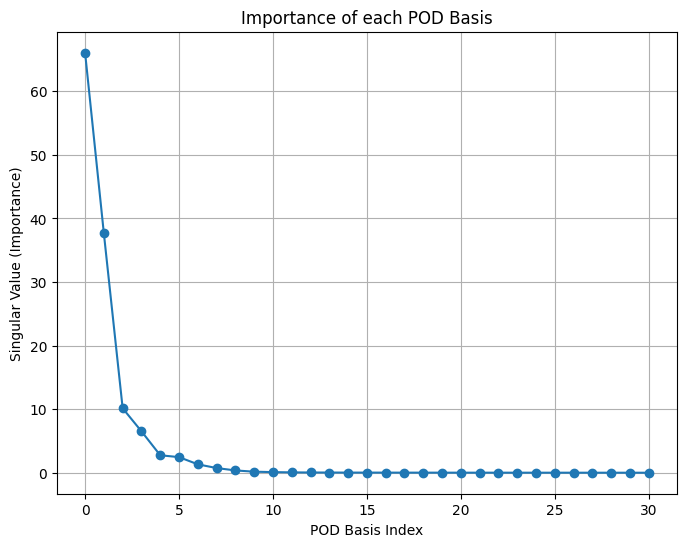

In [28]:
"""
POD Analysis of Deformation Fields

This script performs Proper Orthogonal Decomposition (POD) analysis on the deformation
fields between unloaded and deformed cardiac geometries using SVD.
"""

def read_vtk_coordinates(filename):
    """
    Read VTK file and extract point coordinates.
    Args:
        filename (str): Path to the VTK file
    Returns:
        np.array: Point coordinates (N, 3)
    """
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    geometry = reader.GetOutput()

    points = geometry.GetPoints()
    num_points = points.GetNumberOfPoints()
    coords = np.array([points.GetPoint(i) for i in range(num_points)])
    return coords

def extract_numeric_suffix(filename):
    """
    Extract numeric index from VTK filename.
    Args:
        filename (str): VTK filename (e.g., 't1.vtk')
    Returns:
        int: Numeric suffix or infinity for non-matching files
    """
    match = re.search(r'(\d+)\.vtk$', filename)
    return int(match.group(1)) if match else float('inf')

# ===== Setup Paths =====
deformed_directory = path + '/tetra_vtks'
unloaded_file = path + f'/tetra_vtks/t{unloaded_frame_index}.vtk'

# ===== Load Reference Geometry =====
unloaded_coords = read_vtk_coordinates(unloaded_file)

# ===== Process Deformed Geometries =====
# Get and sort VTK files
vtk_files = [f for f in os.listdir(deformed_directory) if f.endswith('.vtk')]
vtk_files = sorted(vtk_files, key=extract_numeric_suffix)

# Calculate relative displacements
deformation_matrix = []
for vtk_file in vtk_files:
    # Load deformed geometry
    filename = os.path.join(deformed_directory, vtk_file)
    deformed_coords = read_vtk_coordinates(filename)
    
    # Compute and store displacement
    relative_displacement = (deformed_coords - unloaded_coords).flatten()
    deformation_matrix.append(relative_displacement)

# ===== Perform POD Analysis =====
# Convert to numpy array
deformation_matrix = np.array(deformation_matrix)

# Compute SVD
U, S, VT = np.linalg.svd(deformation_matrix, full_matrices=False)

# ===== Visualize Results =====
plt.figure(figsize=(8, 6))
plt.plot(S, marker='o')
plt.xlabel('POD Basis Index')
plt.ylabel('Singular Value (Importance)')
plt.title('Importance of each POD Basis')
plt.grid(True)
plt.show()

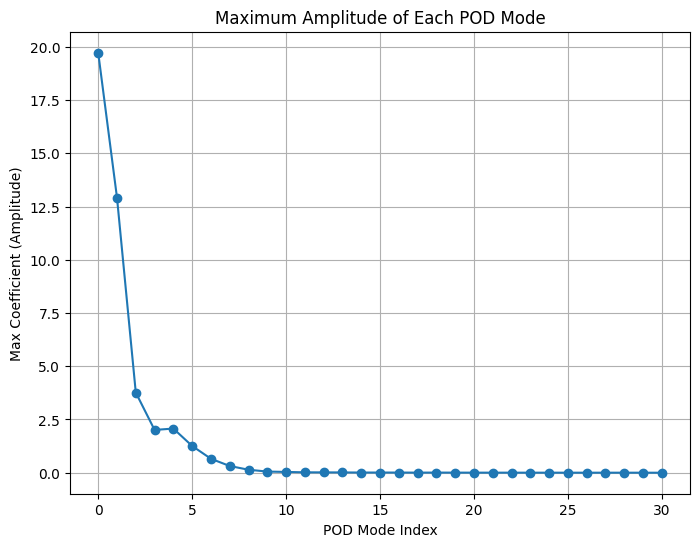

In [29]:
"""
POD Coefficients Analysis and Storage

This script computes and saves POD coefficients and shape modes,
visualizing the maximum amplitude of each mode.
"""

# ===== Compute POD Coefficients =====
# Project data onto POD modes
coefficients = U @ np.diag(S)

# Calculate maximum amplitude for each mode
max_coefficients = np.max(np.abs(coefficients), axis=0)

# ===== Save Results =====
# Create output directory
output_directory = path + '/POD_basis/'
os.makedirs(output_directory, exist_ok=True)

# Save maximum coefficients
max_coefficients_filename = os.path.join(output_directory, 'max_coefficients.npy')
np.save(max_coefficients_filename, max_coefficients)
# print(f"Max coefficients saved to {max_coefficients_filename}")

# Save shape modes
shape_modes_filename = os.path.join(output_directory, 'shape_modes.npy')
np.save(shape_modes_filename, VT)
# print(f"Shape modes saved to {shape_modes_filename}")

# ===== Visualize Results =====
plt.figure(figsize=(8, 6))
plt.plot(max_coefficients, marker='o')
plt.xlabel('POD Mode Index')
plt.ylabel('Max Coefficient (Amplitude)')
plt.title('Maximum Amplitude of Each POD Mode')
plt.grid(True)
plt.show()

<font size="5">Part 8-2: POD Geometry Reconstruction Validation

In [ ]:
# """
# POD-based Geometry Reconstruction

# This script reconstructs geometries using POD modes and coefficients:
# 1. Splits POD modes into x, y, z components
# 2. Reconstructs deformed shapes using specified number of modes
# 3. Saves reconstructed geometries and coefficients
# """

# import vtk
# import numpy as np
# import os

# def read_vtk_file(filepath):
#     """
#     Read VTK file and return unstructured grid.
#     Args:
#         filepath (str): Path to VTK file
#     Returns:
#         vtk.vtkUnstructuredGrid: VTK geometry object
#     """
#     reader = vtk.vtkUnstructuredGridReader()
#     reader.SetFileName(filepath)
#     reader.Update()
#     return reader.GetOutput()

# def save_vtk_file(geometry, filename):
#     """
#     Save geometry to VTK file.
#     Args:
#         geometry (vtk.vtkUnstructuredGrid): Geometry to save
#         filename (str): Output file path
#     """
#     writer = vtk.vtkUnstructuredGridWriter()
#     writer.SetFileName(filename)
#     writer.SetInputData(geometry)
#     writer.Write()

# def reconstruct_geometry_from_pod(geometry, Phix_s, Phiy_s, Phiz_s, coefficients):
#     """
#     Reconstruct geometry using POD basis vectors and coefficients.
#     Args:
#         geometry (vtk.vtkUnstructuredGrid): Base geometry to modify
#         Phix_s, Phiy_s, Phiz_s (np.array): POD modes for x, y, z directions
#         coefficients (np.array): Mode coefficients
#     """
#     points = geometry.GetPoints()
#     num_points = points.GetNumberOfPoints()

#     # Calculate displacements
#     x_contribution = Phix_s @ coefficients
#     y_contribution = Phiy_s @ coefficients
#     z_contribution = Phiz_s @ coefficients

#     # Apply displacements
#     for i in range(num_points):
#         x, y, z = points.GetPoint(i)
#         points.SetPoint(i, 
#                        x + x_contribution[i],
#                        y + y_contribution[i],
#                        z + z_contribution[i])

#     geometry.SetPoints(points)

# # ===== Setup Output Directories =====
# # Create directories for results
# output_directory = path
# reconstructed_directory = os.path.join(output_directory, 'reconstructed/')
# coefficients_directory = os.path.join(output_directory, 'coefficients/')
# os.makedirs(reconstructed_directory, exist_ok=True)
# os.makedirs(coefficients_directory, exist_ok=True)

# # ===== Load Reference Geometry =====
# original_geometry = read_vtk_file(f"{path}/tetra_vtks/t{unloaded_frame_index}.vtk")

# # ===== Split POD Modes =====
# # Extract directional components
# Phix_s = VT[:num_modes, 0::3].T  # x direction (columns 0, 3, 6, ...)
# Phiy_s = VT[:num_modes, 1::3].T  # y direction (columns 1, 4, 7, ...)
# Phiz_s = VT[:num_modes, 2::3].T  # z direction (columns 2, 5, 8, ...)

# # ===== Reconstruct Geometries =====
# for idx in range(len(vtk_files)):
#     # Get coefficients for current time step
#     coefficients = U[idx, :num_modes] * S[:num_modes]

#     # Create base geometry for reconstruction
#     reconstructed_geometry = vtk.vtkUnstructuredGrid()
#     reconstructed_geometry.DeepCopy(original_geometry)

#     # Apply POD reconstruction
#     reconstruct_geometry_from_pod(
#         reconstructed_geometry,
#         Phix_s, Phiy_s, Phiz_s,
#         coefficients
#     )

#     # Save results
#     save_vtk_file(
#         reconstructed_geometry,
#         os.path.join(reconstructed_directory, f"Reconstructed_{idx:02d}.vtk")
#     )
#     np.save(
#         os.path.join(coefficients_directory, f"coefficients_{idx:02d}.npy"),
#         coefficients
#     )

# # print(f"Reconstructed geometries saved in {reconstructed_directory}")

Average Dice coefficient: 1.0000


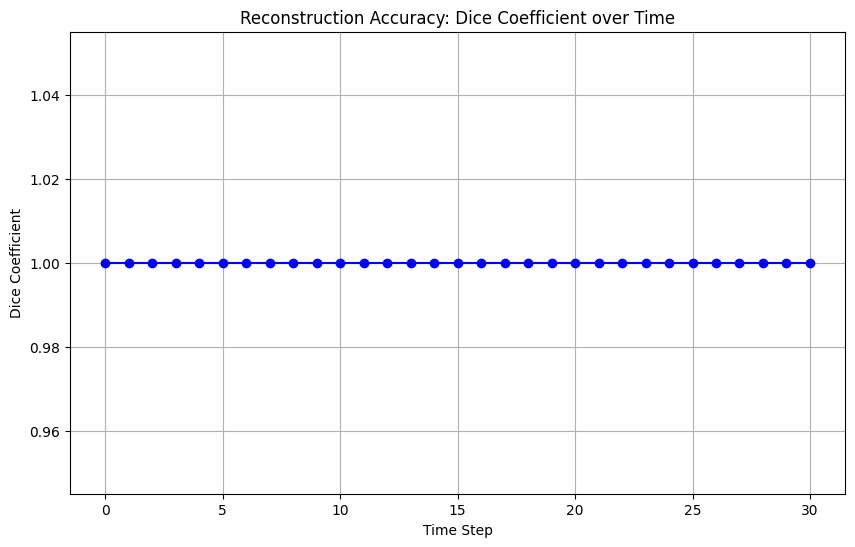

In [ ]:
# """
# Geometry Reconstruction Validation

# This script compares original and reconstructed geometries using Dice coefficient:
# 1. Loads original and reconstructed geometries
# 2. Computes Dice coefficient for each pair
# 3. Visualizes the comparison results
# """

# import vtk
# import numpy as np
# import os
# from scipy.spatial import cKDTree
# import matplotlib.pyplot as plt

# def read_vtu_file(filename):
#     """
#     Read VTU file and return unstructured grid.
#     Args:
#         filename (str): Path to VTU file
#     Returns:
#         vtk.vtkUnstructuredGrid: VTK geometry
#     """
#     reader = vtk.vtkXMLUnstructuredGridReader()
#     reader.SetFileName(filename)
#     reader.Update()
#     return reader.GetOutput()

# def read_vtk_file(filename):
#     """
#     Read VTK file and return unstructured grid.
#     Args:
#         filename (str): Path to VTK file
#     Returns:
#         vtk.vtkUnstructuredGrid: VTK geometry
#     """
#     reader = vtk.vtkUnstructuredGridReader()
#     reader.SetFileName(filename)
#     reader.Update()
#     return reader.GetOutput()

# def get_points_from_geometry(geometry):
#     """
#     Extract point coordinates from VTK geometry.
#     Args:
#         geometry (vtk.vtkUnstructuredGrid): Input geometry
#     Returns:
#         np.ndarray: Point coordinates (N, 3)
#     """
#     points = geometry.GetPoints()
#     num_points = points.GetNumberOfPoints()
#     point_data = np.zeros((num_points, 3))
#     for i in range(num_points):
#         point_data[i] = points.GetPoint(i)
#     return point_data

# def calculate_dice_coefficient(original_points, reconstructed_points, tolerance=0.01):
#     """
#     Calculate Dice coefficient between two point sets.
#     Args:
#         original_points (np.ndarray): Original points
#         reconstructed_points (np.ndarray): Reconstructed points
#         tolerance (float): Distance threshold for point matching
#     Returns:
#         float: Dice coefficient
#     """
#     # Build KD-trees for spatial matching
#     tree_orig = cKDTree(original_points)
#     tree_recon = cKDTree(reconstructed_points)
    
#     # Find matching points within tolerance
#     matches_orig = tree_orig.query_ball_tree(tree_recon, r=tolerance)
#     matches_recon = tree_recon.query_ball_tree(tree_orig, r=tolerance)
    
#     # Calculate Dice coefficient
#     intersection = sum([len(matches) > 0 for matches in matches_orig])
#     size_orig = original_points.shape[0]
#     size_recon = reconstructed_points.shape[0]
    
#     return (2.0 * intersection) / (size_orig + size_recon)

# # ===== Setup Directories =====
# original_directory = path + '/tetra_vtks/'
# reconstructed_directory = path + '/reconstructed/'

# # ===== Compute Dice Scores =====
# dice_scores = []
# for idx, vtk_file in enumerate(vtk_files):
#     # Load geometries
#     original_file = os.path.join(original_directory, vtk_file)
#     reconstructed_file = os.path.join(reconstructed_directory, f"Reconstructed_{idx:02d}.vtk")
    
#     original_geometry = read_vtk_file(original_file)
#     reconstructed_geometry = read_vtk_file(reconstructed_file)
    
#     # Extract points
#     original_points = get_points_from_geometry(original_geometry)
#     reconstructed_points = get_points_from_geometry(reconstructed_geometry)
    
#     # Calculate Dice coefficient
#     dice = calculate_dice_coefficient(original_points, reconstructed_points)
#     dice_scores.append(dice)

# # ===== Report Results =====
# average_dice = np.mean(dice_scores)
# print(f"Average Dice coefficient: {average_dice:.4f}")

# # ===== Visualize Results =====
# plt.figure(figsize=(8, 6))
# plt.plot(dice_scores, marker='o', linestyle='-', color='b')
# plt.xlabel('Time Step')
# plt.ylabel('Dice Coefficient')
# plt.title('Reconstruction Accuracy: Dice Coefficient over Time')
# plt.grid(True)
# plt.show()

<font size="5">Part 9: Get parameters that main script required

In [31]:
print("end_diastolic_time = 0")
print(f"start_diastolic_time = {unloaded_frame_index+1}")
print(f"t_gap = {int(time_period/len(chamber_volumes))}")
print(f"ED_pressure =  {EDP}")
print(f"num_time = {len(chamber_volumes)-1}")
print(f"min_volume_time = {min_volume_index}")
print(f"PS_pressure = {PSP}")
print(f"t0 = {t0}")

end_diastolic_time = 0
start_diastolic_time = 18
t_gap = 25
ED_pressure =  11
num_time = 30
min_volume_time = 11
PS_pressure = 125
t0 = 171
